In [1]:
import os
from glob import glob
import torchaudio
from tqdm import tqdm

# Define folders containing audio files
train_folder = "/kaggle/input/speechocean762/train"
test_folder = "/kaggle/input/speechocean762/test"
saa_folder = "/kaggle/input/speech-accent-archive/recordings/recordings"

def get_wav_files_from_folder(folder_path):
    """Get all .wav files from a given folder."""
    return glob(os.path.join(folder_path, "**/*.wav"), recursive=True)

def get_total_audio_length(audio_files):
    """Calculate the total length of audio files."""
    total_length = 0.0
    for audio_file in tqdm(audio_files):
        waveform, sample_rate = torchaudio.load(audio_file)
        total_length += waveform.shape[1] / sample_rate
    return total_length

# Get all .wav files from the folders
train_wav_files = get_wav_files_from_folder(train_folder)
test_wav_files = get_wav_files_from_folder(test_folder)
saa_wav_files = get_wav_files_from_folder(saa_folder)

# Combine all audio file paths into a single list
audio_files = train_wav_files + test_wav_files + saa_wav_files

print(f"Found {len(audio_files)} audio files.")

# Calculate total audio length
total_audio_length = get_total_audio_length(audio_files)
print(f"Total audio length: {total_audio_length / 3600:.2f} hours.")

# Optionally, save the list of audio files to a text file
output_file = "/kaggle/working/audio_files.txt"
with open(output_file, "w") as f:
    for audio_file in audio_files:
        f.write(f"{audio_file}\n")

print(f"Audio file paths saved to {output_file}.")

Found 5000 audio files.


100%|██████████| 5000/5000 [02:01<00:00, 41.28it/s]

Total audio length: 5.57 hours.
Audio file paths saved to /kaggle/working/audio_files.txt.


In [2]:
import polars as pl
from glob import glob
import os

def calculate_accent_means_by_folder(folders, base_path):
    """
    Calculate the mean of 'Mean' column values for each folder and file,
    then aggregate results into a single DataFrame with additional columns.

    Parameters:
        folders (list): List of folder names to process.
        base_path (str): Base directory containing the folders.

    Returns:
        pl.DataFrame: Aggregated DataFrame with folder-wise mean columns and overall mean.
    """
    all_data = []

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        csv_paths = glob(f"{folder_path}/*.csv")

        for file_path in csv_paths:
            try:
                # Read each CSV into a Polars DataFrame
                df = pl.read_csv(file_path)

                # Add a column with the folder and file base name for identification
                file_basename = os.path.splitext(os.path.basename(file_path))[0]
                column_suffix = f"{folder}_{file_basename}_score"

                # Rename the 'Mean' column with folder and file name as suffix
                df = df.rename({"Mean": column_suffix})

                # Append the DataFrame to the list
                all_data.append(df)
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

    if not all_data:
        raise ValueError("No valid data found in the specified folders.")

    # Perform an outer join on the 'Accent' column to concatenate data horizontally
    result = all_data[0]
    for df in all_data[1:]:
        result = result.join(df, on="Accent")

    # Calculate means for each folder and overall mean
    for folder in folders:
        folder_mean_columns = [col for col in result.columns if col.startswith(folder)]
        if folder_mean_columns:
            result = result.with_columns(
                pl.concat_list([pl.col(col) for col in folder_mean_columns])
                .list.eval(pl.element().mean())
                .alias(f"{folder}_mean")
            )
            result = result.with_columns(
                pl.col(f"{folder}_mean").list.get(0).alias(f"{folder}_mean")
            )
    
    # Calculate the mean across all mean columns
    mean_columns = [col for col in result.columns if col.endswith("_score")]
    result = result.with_columns(
        pl.concat_list([pl.col(col) for col in mean_columns])
        .list.eval(pl.element().mean())
        .alias("overall_mean")
    )
    result = result.with_columns(
        pl.col("overall_mean").list.get(0).alias("overall_mean")
    )

    # Sort the result by the overall mean in descending order
    result = result.sort("overall_mean", descending=True)

    # Reorder columns for clarity
    folder_mean_columns = [f"{folder}_mean" for folder in folders]
    columns_order = ["Accent", "overall_mean"] + folder_mean_columns + [col for col in result.columns if col.endswith("_score")]
    result = result.select(columns_order)

    return result

# Example usage
folders = ["tiny", "base", "small", "medium"]
base_path = "/kaggle/input/whisper-size-comparison-ds"

accent_means = calculate_accent_means_by_folder(folders, base_path)
accent_means.write_csv("all.csv")
accent_means


Accent,overall_mean,tiny_mean,base_mean,small_mean,medium_mean,tiny_test_accent_means_score,tiny_speech-accent-archive_accent_means_score,tiny_train_accent_means_score,base_test_accent_means_score,base_speech-accent-archive_accent_means_score,base_train_accent_means_score,small_test_accent_means_score,small_speech-accent-archive_accent_means_score,small_train_accent_means_score,medium_test_accent_means_score,medium_speech-accent-archive_accent_means_score,medium_train_accent_means_score
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""English""",0.742917,0.729646,0.697694,0.779487,0.76484,0.659904,0.873917,0.655118,0.625442,0.84728,0.620359,0.727097,0.883963,0.7274,0.708223,0.881097,0.705199
"""Chinese""",0.078309,0.06372,0.084371,0.067835,0.097311,0.095298,0.002052,0.093809,0.119407,0.003902,0.129803,0.093885,0.001057,0.108563,0.13598,0.001387,0.154566
"""Latin""",0.01677,0.015768,0.022985,0.01321,0.015118,0.013562,0.017809,0.015933,0.024431,0.015604,0.028919,0.01612,0.006428,0.017082,0.020535,0.006542,0.018276
"""Japanese""",0.015022,0.020378,0.018491,0.010907,0.010311,0.027115,0.003903,0.030117,0.024337,0.004534,0.026602,0.014955,0.00393,0.013835,0.012902,0.003717,0.014313
"""Korean""",0.012196,0.015382,0.014424,0.009992,0.008988,0.020559,0.004654,0.020934,0.018852,0.004993,0.019426,0.014038,0.004093,0.011845,0.010276,0.007306,0.00938
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Hausa""",0.000003,0.000002,0.000002,0.000001,0.000009,0.000001,0.000002,0.000001,0.000002,0.000001,0.000002,4.0039e-7,0.000003,3.3311e-7,0.000014,0.000003,0.00001
"""Malagasy""",6.3074e-7,2.4738e-7,2.9980e-7,1.3642e-7,0.000002,2.4800e-7,1.9378e-7,3.0036e-7,3.3857e-7,1.7661e-7,3.8421e-7,1.5035e-7,1.5930e-7,9.9603e-8,0.000003,3.5841e-7,0.000002
"""Uzbek""",5.8724e-7,8.4483e-8,0.000002,3.5962e-7,2.7791e-7,5.8324e-8,3.6602e-8,1.5852e-7,0.000002,6.0810e-7,0.000002,9.7222e-8,5.0693e-7,4.7470e-7,4.9876e-7,7.8710e-8,2.5626e-7


In [3]:
import matplotlib.pyplot as plt


def calculate_errors(summary_df, biggest_size="medium"):
    folders = ["tiny", "base", "small", biggest_size]
    mean_columns = [f"{folder}_mean" for folder in folders if folder != biggest_size]
    for col in mean_columns:
        summary_df = summary_df.with_columns(
            (summary_df[col] - summary_df[f"{biggest_size}_mean"]).abs().alias(f"{col}_error")
        )
    return summary_df


summary_columns = ["Accent"] + [f"{folder}_mean" for folder in folders]
summary_df = accent_means.select(summary_columns)
summary_df.write_csv("summary_means.csv")

summary_df = calculate_errors(summary_df)
summary_df


Accent,tiny_mean,base_mean,small_mean,medium_mean,tiny_mean_error,base_mean_error,small_mean_error
str,f64,f64,f64,f64,f64,f64,f64
"""English""",0.729646,0.697694,0.779487,0.76484,0.035193,0.067146,0.014647
"""Chinese""",0.06372,0.084371,0.067835,0.097311,0.033591,0.01294,0.029476
"""Latin""",0.015768,0.022985,0.01321,0.015118,0.00065,0.007867,0.001908
"""Japanese""",0.020378,0.018491,0.010907,0.010311,0.010068,0.00818,0.000596
"""Korean""",0.015382,0.014424,0.009992,0.008988,0.006395,0.005436,0.001005
…,…,…,…,…,…,…,…
"""Hausa""",0.000002,0.000002,0.000001,0.000009,0.000007,0.000007,0.000008
"""Malagasy""",2.4738e-7,2.9980e-7,1.3642e-7,0.000002,0.000002,0.000002,0.000002
"""Uzbek""",8.4483e-8,0.000002,3.5962e-7,2.7791e-7,1.9343e-7,0.000001,8.1707e-8


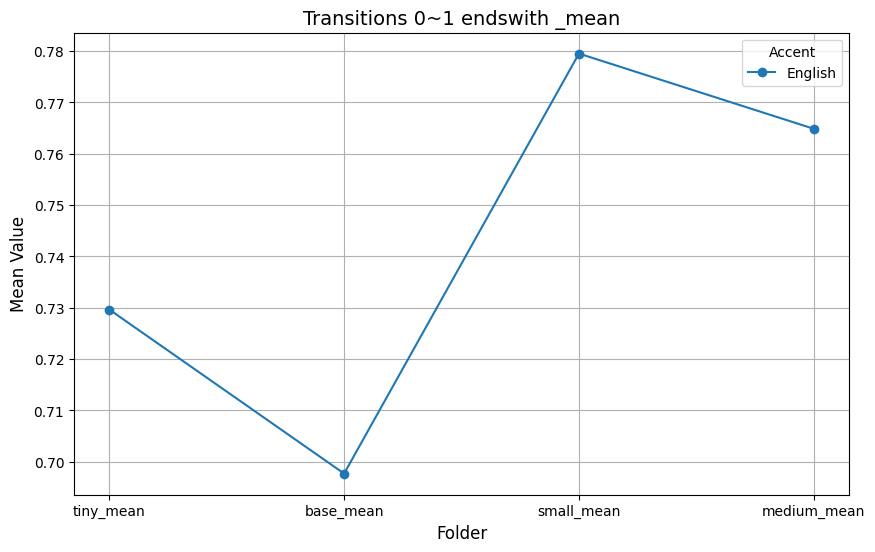

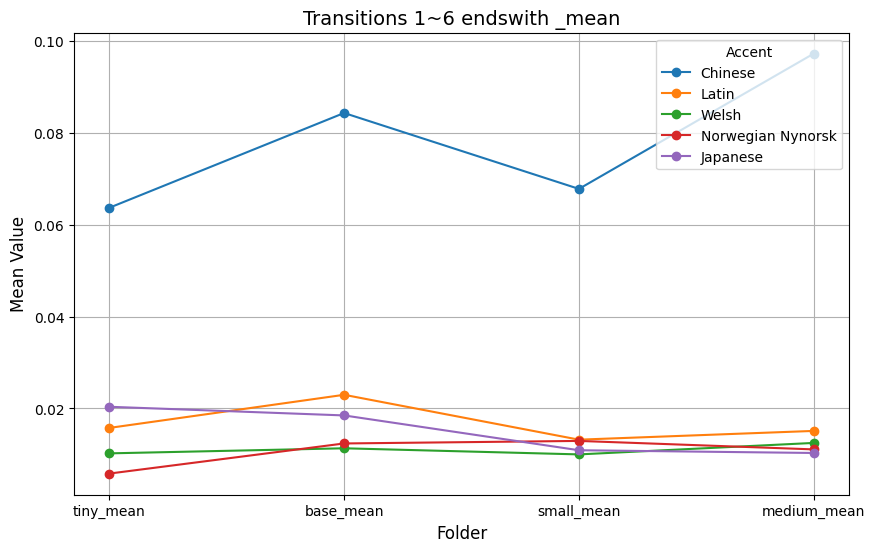

In [4]:
import matplotlib.pyplot as plt

def plot_transitions(overall_df, extract=slice(1,6), endswith="_mean"):
    top_5_df = overall_df.sort("medium_mean", descending=True)[extract]

    # Transpose data for plotting
    accents = top_5_df["Accent"].to_list()
    mean_columns = [col for col in overall_df.columns if col.endswith(endswith)]
    transposed_data = top_5_df.select(mean_columns).to_pandas()

    # Plot transition graph
    plt.figure(figsize=(10, 6))
    for i, accent in enumerate(accents):
        plt.plot(mean_columns, transposed_data.iloc[i], marker='o', label=accent)

    plt.title(f"Transitions {extract.start}~{extract.stop} endswith {endswith}", fontsize=14)
    plt.xlabel("Folder", fontsize=12)
    plt.ylabel("Mean Value", fontsize=12)
    plt.legend(title="Accent", loc="upper right")
    plt.grid(True)
    plt.show()


plot_transitions(summary_df, extract=slice(0, 1))
plot_transitions(summary_df)

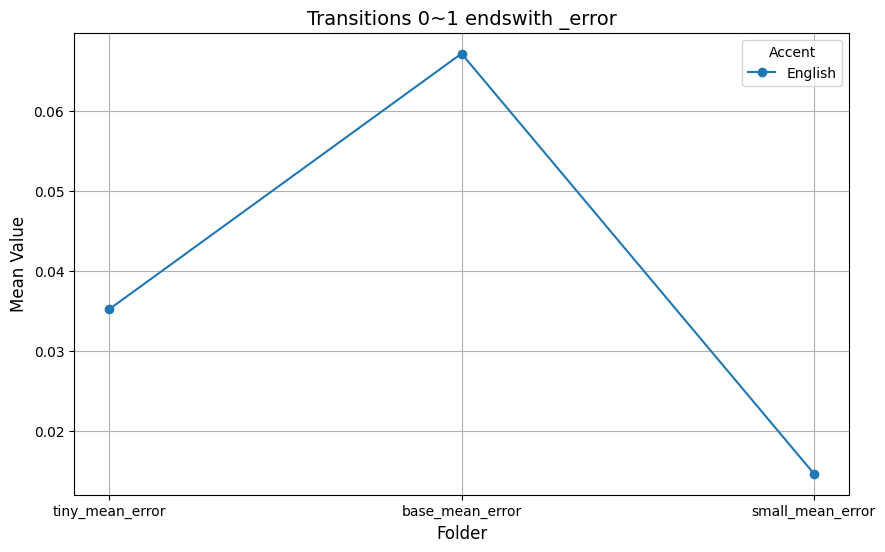

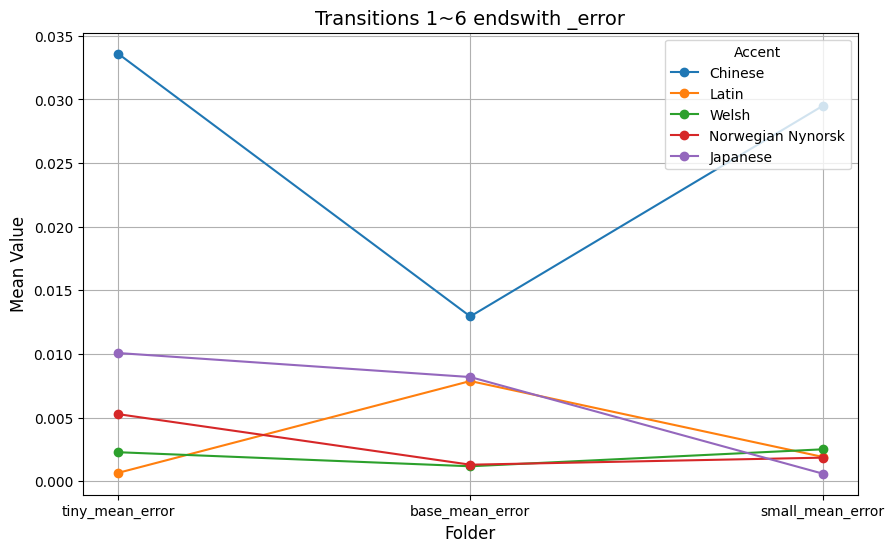

In [5]:
plot_transitions(summary_df, extract=slice(0, 1), endswith="_error")
plot_transitions(summary_df, endswith="_error")

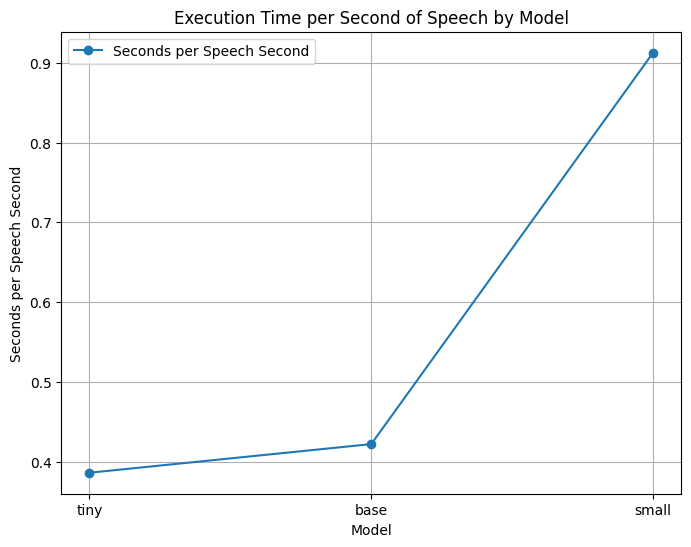

In [6]:
import polars as pl
import matplotlib.pyplot as plt

# Data preparation
total_audio_seconds = 20052
execute_seconds = {
    "tiny": 7740,
    "base": 8460,
    "small": 18300,
}

data = pl.DataFrame({
    "Model": list(execute_seconds.keys()),
    "Execute_Seconds": list(execute_seconds.values())
})

# Calculate seconds per speech second
data = data.with_columns(
    (data["Execute_Seconds"] / total_audio_seconds).alias("Seconds_Per_Speech_Second")
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(data["Model"], data["Seconds_Per_Speech_Second"], marker='o', label="Seconds per Speech Second")
plt.title("Execution Time per Second of Speech by Model")
plt.xlabel("Model")
plt.ylabel("Seconds per Speech Second")
plt.grid(True)
plt.legend()
plt.show()